<a href="https://colab.research.google.com/github/Soumya-52564/Ai_MoodMate/blob/main/Aimoodmate2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/AI_MoodMate/fer-2013.zip"
extract_path = "/content/fer2013"

# Extract only if not already extracted
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Check folders
print(os.listdir(extract_path))


['val', 'train', 'test']


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "/content/fer2013/train",
    target_size=(48,48),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32
)

val_generator = val_datagen.flow_from_directory(
    "/content/fer2013/val",
    target_size=(48,48),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32
)


Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [ ]:
def conv_block(x, filters, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, 3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x


def build_resnet18_gray(input_shape=(48,48,1), num_classes=7):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # 4 stages (ResNet18 pattern)
    for filters, blocks, stride in [(64,2,1), (128,2,2), (256,2,2), (512,2,2)]:
        for b in range(blocks):
            x = conv_block(x, filters, stride if b == 0 else 1)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model


model = build_resnet18_gray()
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 24, 24,    │      3,136 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 24, 24,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 24, 24,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 12, 12,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 12, 12,    │     36,864 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 12, 12,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 12,    │     36,864 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 12, 12,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 12, 12,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │     36,864 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 12, 12,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 12, 12,    │     36,864 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ conv2d_4[0][0]  

 Total params: 11,183,431 (42.66 MB)

 Trainable params: 11,173,831 (42.62 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [ ]:
callbacks = [
    ModelCheckpoint("resnet18_gray_best.keras", monitor="val_accuracy", save_best_only=True, mode="max"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=5, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 64s 49ms/step - accuracy: 0.2021 - loss: 2.3308 - val_accuracy: 0.2572 - val_loss: 1.7769 - learning_rate: 1.0000e-04
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 32s 36ms/step - accuracy: 0.2200 - loss: 1.9191 - val_accuracy: 0.2683 - val_loss: 1.8240 - learning_rate: 1.0000e-04
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.2295 - loss: 1.8723 - val_accuracy: 0.3029 - val_loss: 1.7269 - learning_rate: 1.0000e-04
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.2399 - loss: 1.8495 - val_accuracy: 0.3104 - val_loss: 1.7293 - learning_rate: 1.0000e-04
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.2575 - loss: 1.8107 - val_accuracy: 0.3243 - val_loss: 1.6835 - learning_rate: 1.0000e-04
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.2871 - loss: 1.7583 - val_accuracy: 0.3717 - val_loss: 1.6013 - learning_rate: 1.0000e-04
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accurac

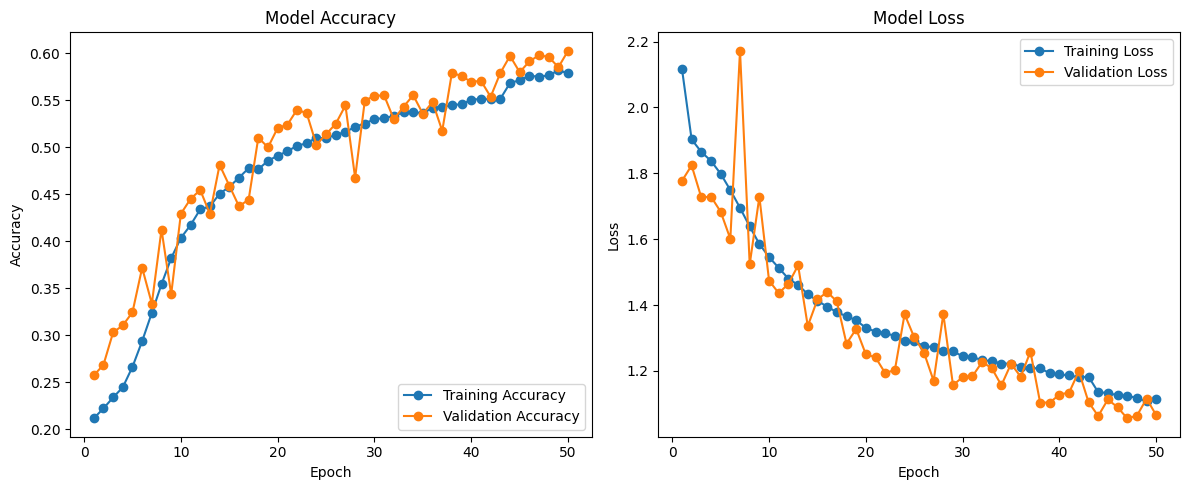

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy and loss curves
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12,5))

    # Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [ ]:
best_model = tf.keras.models.load_model("resnet18_gray_best.keras")
val_loss, val_acc = best_model.evaluate(val_generator, batch_size=32)
print("Validation Accuracy:", round(val_acc*100, 2), "%")


113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.5972 - loss: 1.0631
Validation Accuracy: 60.27 %


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np


# ---------------------------
# 1️⃣ ResNet18 block (same)
# ---------------------------
def conv_block(x, filters, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, 3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x


# ---------------------------
# 2️⃣ ResNet18 model builder
# ---------------------------
def build_resnet18_gray(input_shape=(48, 48, 1), num_classes=7):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # 4 stages (ResNet18 pattern)
    for filters, blocks, stride in [(64, 2, 1), (128, 2, 2), (256, 2, 2), (512, 2, 2)]:
        for b in range(blocks):
            x = conv_block(x, filters, stride if b == 0 else 1)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model


# ---------------------------
# 3️⃣ Improved data augmentation
# ---------------------------
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    "fer2013/train",
    target_size=(48, 48),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=64
)

val_generator = val_datagen.flow_from_directory(
    "fer2013/val",
    target_size=(48, 48),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=64
)


# ---------------------------
# 4️⃣ Compute class weights (for imbalanced FER)
# ---------------------------
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


# ---------------------------
# 5️⃣ Build & compile model
# ---------------------------
model = build_resnet18_gray()
model.compile(
    optimizer=Adam(learning_rate=1e-4, decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


# ---------------------------
# 6️⃣ Callbacks (improved)
# ---------------------------
def scheduler(epoch, lr):
    if epoch < 5:
        return lr * 1.2  # warm-up
    else:
        return lr * 0.98  # gradual decay

callbacks = [
    ModelCheckpoint("resnet18_gray_best.keras", monitor="val_accuracy", save_best_only=True, mode="max"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=5, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
    LearningRateScheduler(scheduler)
]


# ---------------------------
# 7️⃣ Train model
# ---------------------------
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks,
    class_weight=class_weights
)


# ---------------------------
# 8️⃣ Fine-tune (optional)
# ---------------------------
model.load_weights("resnet18_gray_best.keras")
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 24, 24,    │      3,136 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_17 (ReLU)     │ (None, 24, 24,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 12, 12,    │          0 │ re_lu_17[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 12, 12,    │     36,864 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 12, 12,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 12, 12,    │     36,864 │ re_lu_18[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 12, 12,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 12, 12,    │          0 │ add_8[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 12, 12,    │     36,864 │ re_lu_19[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 12, 12,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 12, 12,    │     36,864 │ re_lu_20[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ conv2d_24[0][0] 

 Total params: 11,183,431 (42.66 MB)

 Trainable params: 11,173,831 (42.62 MB)

 Non-trainable params: 9,600 (37.50 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 61s 87ms/step - accuracy: 0.1662 - loss: 2.4963 - val_accuracy: 0.1580 - val_loss: 1.9439 - learning_rate: 1.2000e-04
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.1729 - loss: 2.1043 - val_accuracy: 0.2480 - val_loss: 1.8208 - learning_rate: 1.4400e-04
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.1986 - loss: 1.9892 - val_accuracy: 0.2639 - val_loss: 1.7843 - learning_rate: 1.7280e-04
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.2114 - loss: 1.9512 - val_accuracy: 0.1293 - val_loss: 1.9687 - learning_rate: 2.0736e-04
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.2555 - loss: 1.8705 - val_accuracy: 0.2513 - val_loss: 1.8420 - learning_rate: 2.4883e-04
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.2756 - loss: 1.8255 - val_accuracy: 0.3357 - val_loss: 1.6909 - learning_rate: 2.4386e-04
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/ste

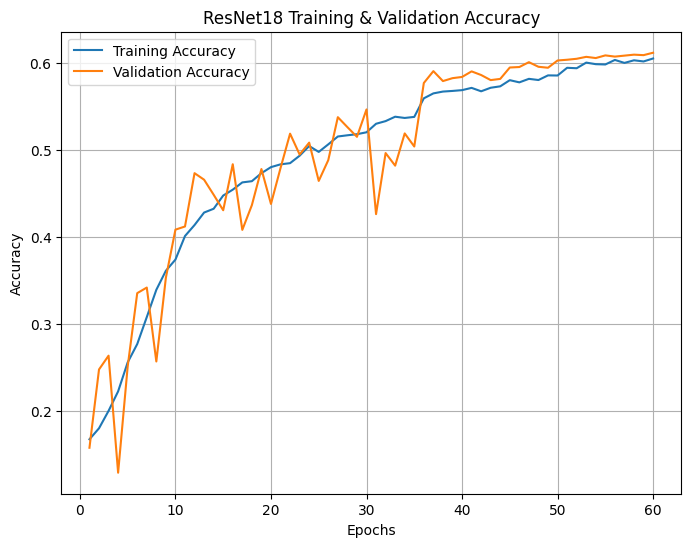

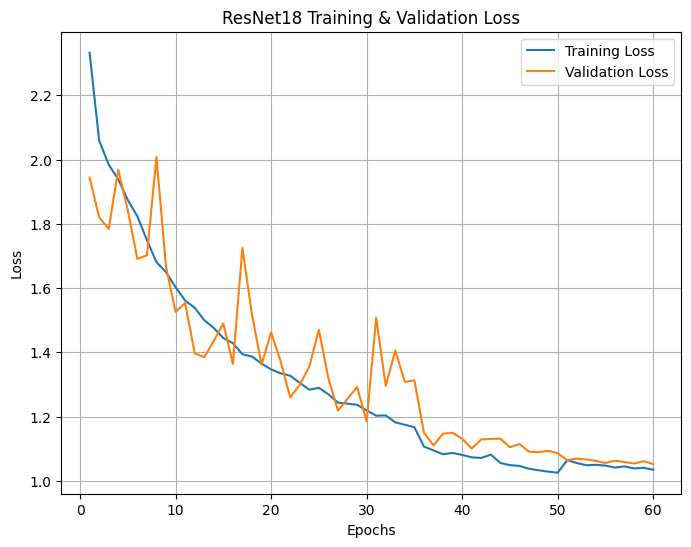


✅ Final Training Accuracy: 60.55%
✅ Final Validation Accuracy: 61.21%


In [ ]:
# --- Plot graphs ---
import matplotlib.pyplot as plt

acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
loss = history.history['loss'] + fine_tune_history.history['loss']
val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('ResNet18 Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('ResNet18 Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- Display final accuracy in percentage ---
final_train_acc = acc[-1] * 100
final_val_acc = val_acc[-1] * 100

print(f"\n✅ Final Training Accuracy: {final_train_acc:.2f}%")
print(f"✅ Final Validation Accuracy: {final_val_acc:.2f}%")


Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Epoch 1/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 53s 81ms/step - accuracy: 0.2244 - loss: 2.3167 - val_accuracy: 0.2703 - val_loss: 1.8161
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - accuracy: 0.3092 - loss: 1.8334 - val_accuracy: 0.3982 - val_loss: 1.5761
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.3298 - loss: 1.7789 - val_accuracy: 0.3887 - val_loss: 1.6060
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 26s 57ms/step - accuracy: 0.3596 - loss: 1.6976 - val_accuracy: 0.4352 - val_loss: 1.5093
Epoch 5/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.3934 - loss: 1.6266 - val_accuracy: 0.4536 - val_loss: 1.4792
Epoch 6/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 26s 57ms/step - accuracy: 0.4223 - loss: 1.5638 - val_accuracy: 0.4706 - val_loss: 1.4310
Epoch 7/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.4202 - loss: 1.5585 - val_accuracy: 0.4489 - val_loss: 1.475

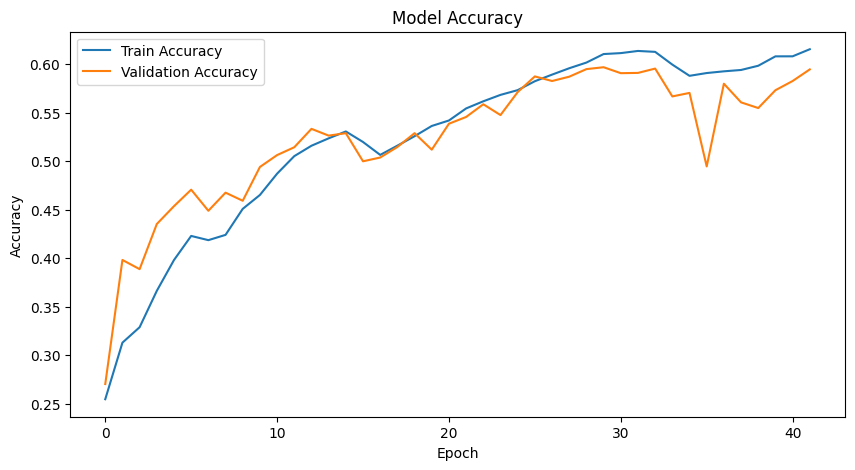

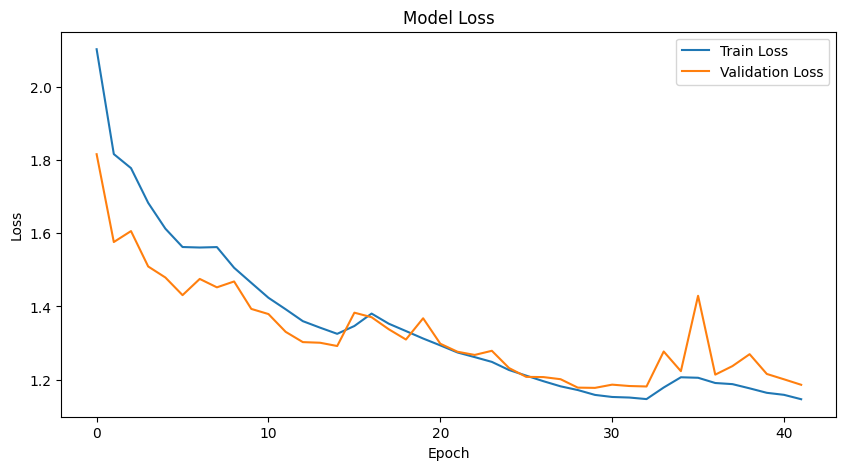

✅ Final Training Accuracy: 61.54%
✅ Final Validation Accuracy: 59.46%


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
import matplotlib.pyplot as plt

# ===============================
# 1️⃣ Data Generators (slightly reduced augmentation)
# ===============================
batch_size = 64
img_size = (48, 48)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "fer2013/train",
    target_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    "fer2013/test",
    target_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical"
)

# ===============================
# 2️⃣ ResNet18 Architecture (unchanged)
# ===============================
def conv_block(x, filters, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, 3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet18_gray(input_shape=(48,48,1), num_classes=7):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    for filters, blocks, stride in [(64,2,1), (128,2,2), (256,2,2), (512,2,2)]:
        for b in range(blocks):
            x = conv_block(x, filters, stride if b == 0 else 1)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

# ===============================
# 3️⃣ Improved Training Schedule
# ===============================
initial_learning_rate = 1e-4
lr_schedule = CosineDecayRestarts(
    initial_learning_rate,
    first_decay_steps=1000,
    t_mul=2.0,
    m_mul=0.9,
    alpha=1e-6
)

model = build_resnet18_gray()

model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=CategoricalCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)

callbacks = [
    ModelCheckpoint("resnet18_gray_best.keras", monitor="val_accuracy", save_best_only=True, mode="max"),
    EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True)
]

# ===============================
# 4️⃣ Train Model
# ===============================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=callbacks
)

# ===============================
# 5️⃣ Plot Results
# ===============================
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

train_acc = history.history['accuracy'][-1] * 100
val_acc = history.history['val_accuracy'][-1] * 100
print(f"✅ Final Training Accuracy: {train_acc:.2f}%")
print(f"✅ Final Validation Accuracy: {val_acc:.2f}%")


Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 24, 24,    │      3,136 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_17 (ReLU)     │ (None, 24, 24,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 12, 12,    │          0 │ re_lu_17[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 12, 12,    │     36,864 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 12, 12,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 12, 12,    │     36,864 │ re_lu_18[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 12, 12,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 12, 12,    │          0 │ add_8[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 12, 12,    │     36,864 │ re_lu_19[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 12, 12,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 12, 12,    │     36,864 │ re_lu_20[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ conv2d_24[0][0] 

 Total params: 11,183,431 (42.66 MB)

 Trainable params: 11,173,831 (42.62 MB)

 Non-trainable params: 9,600 (37.50 KB)

Epoch 1/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 70s 105ms/step - accuracy: 0.2059 - loss: 2.3700 - val_accuracy: 0.2884 - val_loss: 1.8305 - learning_rate: 1.0000e-04
Epoch 2/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 75ms/step - accuracy: 0.2928 - loss: 1.8677 - val_accuracy: 0.3931 - val_loss: 1.6420 - learning_rate: 1.0000e-04
Epoch 3/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - accuracy: 0.3351 - loss: 1.7579 - val_accuracy: 0.4115 - val_loss: 1.6053 - learning_rate: 1.0000e-04
Epoch 4/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 33s 74ms/step - accuracy: 0.3635 - loss: 1.6966 - val_accuracy: 0.4249 - val_loss: 1.5745 - learning_rate: 1.0000e-04
Epoch 5/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - accuracy: 0.3937 - loss: 1.6462 - val_accuracy: 0.4322 - val_loss: 1.5850 - learning_rate: 1.0000e-04
Epoch 6/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 33s 74ms/step - accuracy: 0.4213 - loss: 1.5919 - val_accuracy: 0.4664 - val_loss: 1.5122 - learning_rate: 1.0000e-04
Epoch 7/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 33s 74ms/st

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


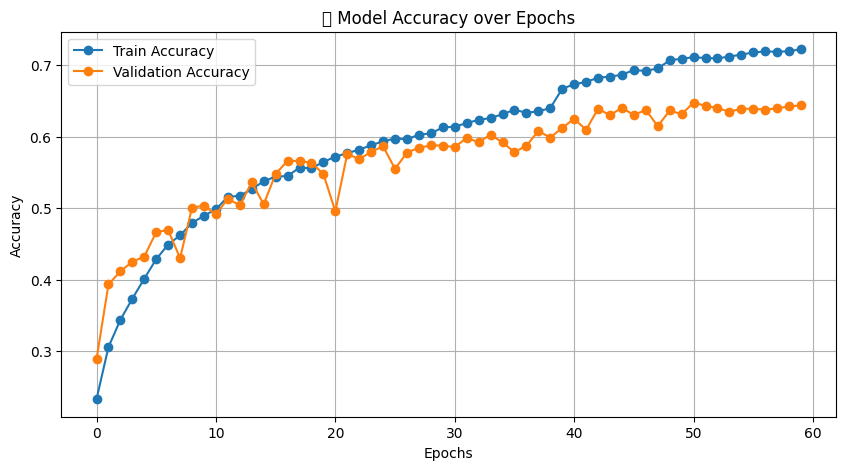

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


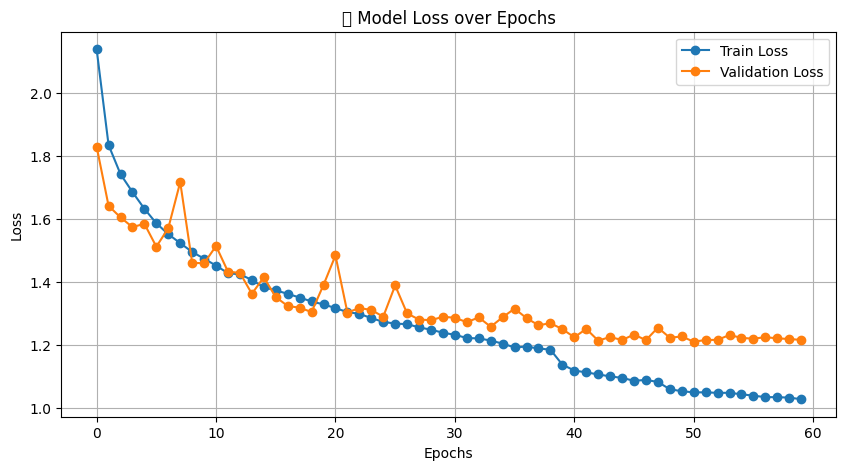


✅ Final Training Accuracy: 72.20%
✅ Final Validation Accuracy: 64.36%


In [ ]:
# =========================================
# ✅ ResNet18 - FER2013 Grayscale Emotion Detection
# =========================================
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt

# =========================================
# 1️⃣ Data Preprocessing (Grayscale, 48×48)
# =========================================
batch_size = 64
img_size = (48, 48)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,           # small rotation
    width_shift_range=0.1,       # horizontal shift
    height_shift_range=0.1,      # vertical shift
    zoom_range=0.1,              # zoom
    shear_range=0.1,             # shear transform
    horizontal_flip=True,        # flip
    brightness_range=[0.8, 1.2], # light variation
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "fer2013/train",
    target_size=img_size,
    color_mode="grayscale",     # 👈 critical fix
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    "fer2013/test",
    target_size=img_size,
    color_mode="grayscale",     # 👈 critical fix
    batch_size=batch_size,
    class_mode="categorical"
)

# =========================================
# 2️⃣ ResNet18 Architecture
# =========================================
def conv_block(x, filters, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, 3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x


def build_resnet18_gray(input_shape=(48,48,1), num_classes=7):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # 4 ResNet stages
    for filters, blocks, stride in [(64,2,1), (128,2,2), (256,2,2), (512,2,2)]:
        for b in range(blocks):
            x = conv_block(x, filters, stride if b == 0 else 1)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model


# =========================================
# 3️⃣ Compile Model
# =========================================
model = build_resnet18_gray()

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.summary()

# =========================================
# 4️⃣ Callbacks
# =========================================
callbacks = [
    ModelCheckpoint("resnet18_gray_best.keras", monitor="val_accuracy", save_best_only=True, mode="max"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=5, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

# =========================================
# 5️⃣ Train Model
# =========================================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=60,
    callbacks=callbacks
)

# =========================================
# 6️⃣ Plot Accuracy and Loss
# =========================================
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('📈 Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('📉 Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# =========================================
# 7️⃣ Final Accuracy Results
# =========================================
train_acc = history.history['accuracy'][-1] * 100
val_acc = history.history['val_accuracy'][-1] * 100
print(f"\n✅ Final Training Accuracy: {train_acc:.2f}%")
print(f"✅ Final Validation Accuracy: {val_acc:.2f}%")


Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 24, 24,    │      3,200 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_34 (ReLU)     │ (None, 24, 24,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 12, 12,    │          0 │ re_lu_34[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 12, 12,    │     36,928 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_35 (ReLU)     │ (None, 12, 12,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 12, 12,    │     36,928 │ re_lu_35[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 12, 12,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_36 (ReLU)     │ (None, 12, 12,    │          0 │ add_16[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 12, 12,    │     36,928 │ re_lu_36[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_37 (ReLU)     │ (None, 12, 12,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 12, 12,    │     36,928 │ re_lu_37[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ conv2d_44[0][0] 

 Total params: 11,251,207 (42.92 MB)

 Trainable params: 11,241,607 (42.88 MB)

 Non-trainable params: 9,600 (37.50 KB)

Epoch 1/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 69s 99ms/step - accuracy: 0.1993 - loss: 2.6088 - val_accuracy: 0.2541 - val_loss: 2.1830 - learning_rate: 1.0000e-04
Epoch 2/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.2398 - loss: 2.1803 - val_accuracy: 0.3098 - val_loss: 2.1097 - learning_rate: 1.0000e-04
Epoch 3/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.2645 - loss: 2.1337 - val_accuracy: 0.3129 - val_loss: 2.0691 - learning_rate: 1.0000e-04
Epoch 4/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.2927 - loss: 2.0873 - val_accuracy: 0.2641 - val_loss: 2.1368 - learning_rate: 1.0000e-04
Epoch 5/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.3247 - loss: 2.0333 - val_accuracy: 0.3739 - val_loss: 1.9579 - learning_rate: 1.0000e-04
Epoch 6/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.3547 - loss: 1.9711 - val_accuracy: 0.3547 - val_loss: 1.9521 - learning_rate: 1.0000e-04
Epoch 7/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/ste

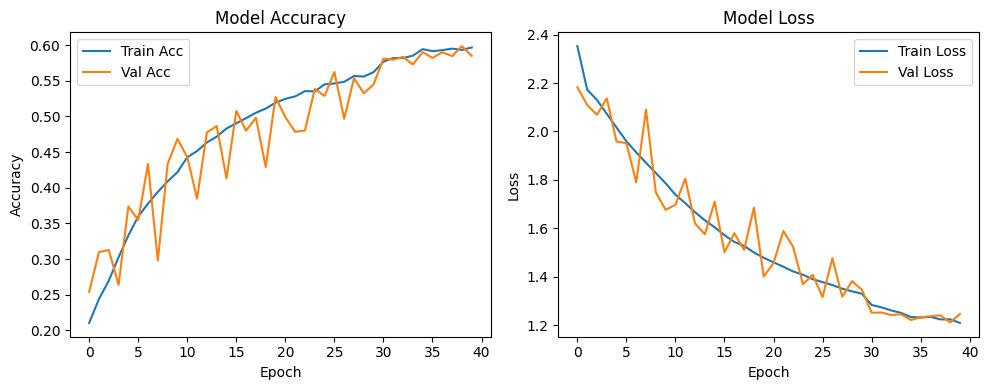

In [ ]:
# ================================================================
# Facial Emotion Recognition using ResNet18-like CNN (Grayscale)
# ================================================================

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# =========================
# 1️⃣ Basic Config
# =========================
img_size = (48, 48)
batch_size = 64
epochs = 40

# =========================
# 2️⃣ Data Preprocessing
# =========================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'fer2013/train',             # path to training data
    target_size=img_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size
)

val_generator = val_datagen.flow_from_directory(
    'fer2013/val',               # path to validation data
    target_size=img_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size
)

num_classes = train_generator.num_classes

# =========================
# 3️⃣ Build ResNet18-like Model
# =========================
def conv_block(x, filters, kernel_size=3, stride=1):
    """Basic Residual Block"""
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)

    # match dimensions
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x


def build_resnet18(input_shape=(48, 48, 1), num_classes=7):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Residual layers (2, 2, 2, 2) — typical of ResNet18
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    x = conv_block(x, 128, stride=2)
    x = conv_block(x, 128)

    x = conv_block(x, 256, stride=2)
    x = conv_block(x, 256)

    x = conv_block(x, 512, stride=2)
    x = conv_block(x, 512)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model


model = build_resnet18(input_shape=(48, 48, 1), num_classes=num_classes)
model.summary()

# =========================
# 4️⃣ Compile
# =========================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# =========================
# 5️⃣ Callbacks
# =========================
early_stop = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, verbose=1, min_lr=1e-6)

# =========================
# 6️⃣ Train
# =========================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr]
)

# =========================
# 7️⃣ Evaluate
# =========================
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)

print(f"\n✅ Final Training Accuracy: {train_acc*100:.2f}%")
print(f"✅ Final Validation Accuracy: {val_acc*100:.2f}%")

# =========================
# 8️⃣ Plot Accuracy & Loss
# =========================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
